# P型フーリエ記述子

輪郭上に等間隔にN+1個の標本点 $P_n$   n=0,1,2, ..., N を取る。ただし、$P_0=P_N$.

$P_n =(x_n,y_n)$ に複素平面上の点 $z_n =　x_n　+ j y_n$ を対応づけ、両者を同一視することにする。

ベクトル$P_{n}P_{n+1}$　と　X軸のなす角$\theta_n$を点$P_{n}$における偏角とよぶ。

ここで、$w_n = cos\theta_n + j sin\theta_n$ と定義する。隣接する標本点同士の直線距離を$\delta$とすると、

$$w_n= cos\theta + j sin\theta = \frac{x_{n+1}-x_n}{\delta} + j \frac{y_{n+1}-y_n}{\delta}=\frac{z_{n+1}-z_n}{\delta}$$

である。

$w_i,   i=0,1,2,...,n$ が与えられたなら、$z_n = z_0 + \delta \sum_{i=0}^{n} w_i$ としてもとの点が復元できる。

$w_n$   n=0,1,2, ..., N　を周期関数とみなせば、 $w_n　= \frac{1}{N}\sum_{k=0}^{N-1}{W_k exp(j \frac{2 \pi k n}{N}})$ とフーリエ級数展開することができる。ここで、

$$W_k=\sum_{n=0}^{N-1}{f_n exp(-j \frac{2 \pi k n}{N}})$$

である。この、$W_i$ をP型フーリエ記述子と呼ぶ。

$W_i$は周期Nの周期関数であり、n=0からN/2までが正の周波数、N/2からNまでが負の周波数に対応し、中央のN/2が最も高い周波数に、０とNが最も低い周波数を表すことに注意が必要である。

## 離散フーリエ逆変換

$W_k$ をフーリエ記述子とするとき、$w_n=\frac{1}{N}\sum_{k=0}^{N-1}{F_n exp(j \frac{2 \pi k n}{N}})$ であり、これより上述のとおり、標本点を復元できる。

## numpy の高速フーリエ変換

計算時間を短縮するために、高速フーリエ変換FFTを用いることにする。ここでは詳細は述べないが、FFTはデータ数Nを２のべき乗に限定することで計算量を抑えたアルゴリズムである。

以下の実験ではN＝１２８とした。この場合、フーリエ記述子のインデックス０はバイアス（直流成分）、１から６３まではが正の周波数で数字の順に周波数が上がっていき、６５から１２７までは負の周波数で、数字が増えるにしたがって周波数が下がっていく。

折り返しの６４は正と負両方の最大周波数となる。つまり、１周で６４周期、２ピクセル１周期の波が最大周波数の波形成分となる。（しごく真っ当である）

In [1]:
import numpy as np
import matplotlib
# matplotlib.use('Agg') # 表示しないモード。バッチ処理する場合、画像表示が多くなりすぎて　notebooke の制限で途中で止まってしまう。
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image
import math
import pandas as pd

from sympy import *
from sympy.abc import a,b,c
# init_session()
px,py =var('px:4'),var('py:4')
t = symbols('t')
from sympy import var
from rdlib2 import *

import datetime
import time

import os

# 輪郭データからのひげ除去
def shaver(cnt):  # 輪郭点列のうち、ヒゲ要素を取り除く
    # まず輪郭列のスタート部分がヒゲ要素を取り除く
    while True:
        if len(cnt) > 2 and list(cnt[1][0])==list(cnt[-1][0]): # 最初の点がヒゲの先端
            cnt = cnt[1:-1]
        else:
            break
    # 途中のヒゲ要素を取り除く
    while True:
            l = len(cnt)
            for  i in range(1,len(cnt)-1):
                    if list(cnt[i-1][0]) == list(cnt[i+1][0]):
                            cnt = np.r_[cnt[:i],cnt[i+2:]]
            if l == len(cnt):
                break
    return cnt

# 輪郭に沿った長さ

        
# (x1,y1)から（x2,y2) に向かう直線のX軸に対する角度(0-359)
def getDegree(x1,y1,x2,y2):
        dx = x2-x1
        dy = y2-y1
        if dx == 0 :
            if dy == 0: # 例外
                deg = 0
            elif dy > 0:
                deg = 90
            else:
                deg = 270
        elif dx >0 and dy >= 0:
            deg = 180.0*np.arctan(dy/dx)/np.pi
        elif dx > 0 and dy < 0: 
            deg = 360+180*np.arctan(dy/dx)/np.pi
        else:
            deg =180*(1+ np.arctan(dy/dx)/np.pi)
            # deg = 270.0(1+np.arctan(dy/dx)/np.pi)
        return deg

In [2]:
kohaku='シルエット/17Cylindric/17kohaku1o09_l.jpg'
yakumi ='シルエット/17Spheric/17yakumi2o06_l.jpg'
daruma='シルエット/17Apically/17daruma6o06_l.jpg'
aomida='シルエット/17Horn/17aomida1o02_l.jpg'
nezumi='シルエット/17Inv_tri/17nezumi1o06_l.jpg'

kohakuimg = getstandardShape(cv2.imread(kohaku,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
akumiimg = getstandardShape(cv2.imread(yakumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
darumaimg = getstandardShape(cv2.imread(daruma,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
aomidaimg = getstandardShape(cv2.imread(aomida,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  
nezumiimg = getstandardShape(cv2.imread(nezumi,cv2.IMREAD_GRAYSCALE), unitSize=UNIT, thres=0.25)  

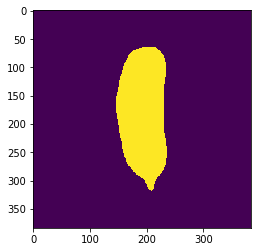

In [3]:
img = kohakuimg
plt.imshow(img)

(194.0, 181.0, (147, 65, 89, 253, 17233))

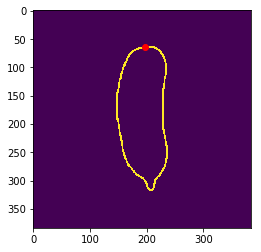

In [4]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
# img = roteteAndCutMargin(img,130,c_x,c_y)
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[0][0][0]],[cnt00[0][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

## まず、経路長を横軸、X,Yを縦軸に取ったグラフ

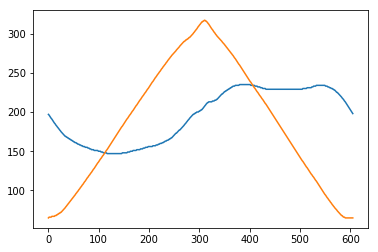

In [5]:
# 輪郭に沿った長さの列 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

# サンプリング
点の数が多すぎるので、128点だけサンプリングしてみる

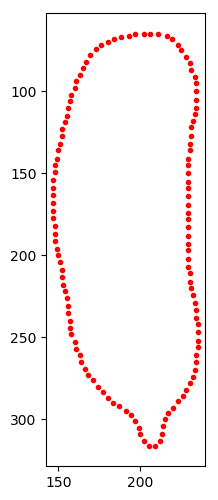

In [6]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
needLengs = np.linspace(0,allLength,SPANS+1)
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

サンプル点だけでX,Yをプロットして十分かどうか確認

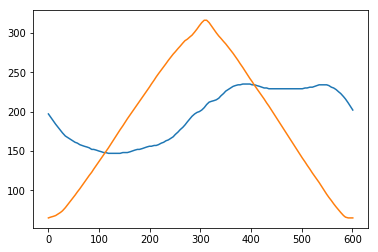

In [7]:
# 128点でプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

# フーリエ変換

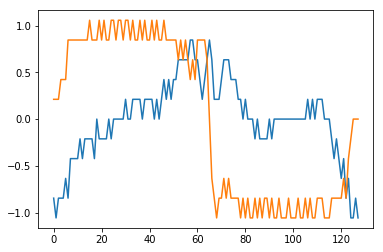

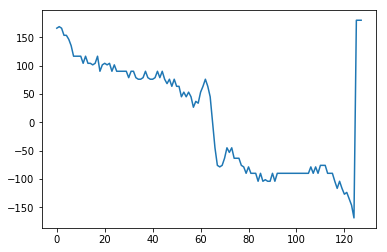

In [8]:
# 複素表現
# (x,y)と 複素数 x+ jy を同一視する。
z = [x + y*1j  for [x,y] in samples]
# 偏角の複素表現
w = [(z1 - z0)/allLength*SPANS for (z1,z0) in zip(z[1:],z[:-1])]
w.append((z[0] - z[-1])/allLength*SPANS)
w = np.array(w)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.real)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.imag)
plt.show()
# 偏角(degree)のプロット
import cmath
ph = [180*cmath.phase(w[0])/np.pi]
for c in w[1:]:
    ph.append((180*cmath.phase(c)/np.pi))
    #ph.append((180*cmath.phase(c)/np.pi) if abs(180*cmath.phase(c)/np.pi - ph[-1]) < 180  else (180*cmath.phase(c)/np.pi -360))
plt.plot(np.linspace(0,SPANS-1,SPANS),ph)

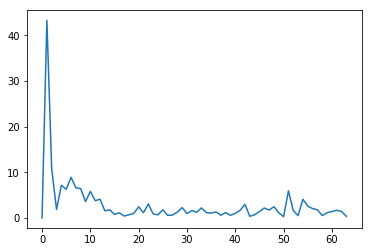

In [9]:
# フーリエ変換
W= np.fft.fft(w)

# スペクトラム表示
W_abs = np.abs(W)
W_abs_amp = W_abs / SPANS *2 # 交流成分はデータ数で割って2倍
W_abs_amp[0] = W_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0,  int(SPANS/2)-1,  int(SPANS/2))
plt.plot(fq, W_abs[: int(SPANS/2)])

# フーリエ逆変換

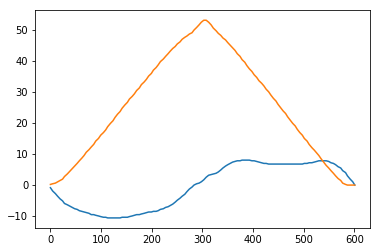

In [10]:
# フーリエ逆変換
w_ifft= np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

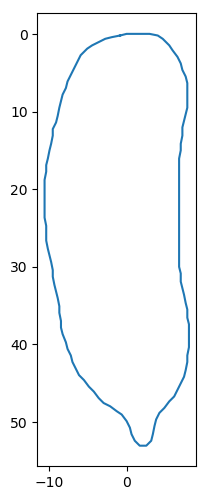

In [11]:
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]])

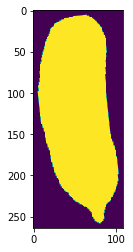

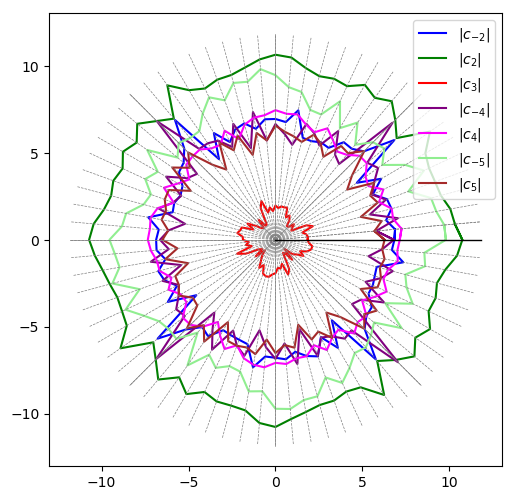

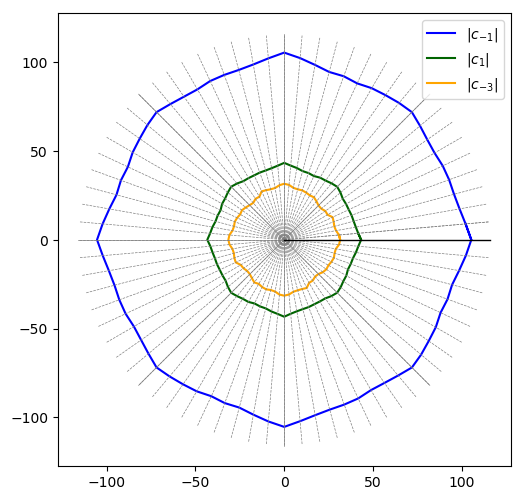

In [12]:
def makefft(angle):
    oimg = kohakuimg
    ### 輪郭情報
    img = roteteAndCutMargin(oimg,angle,c_x,c_y)
    plt.imshow(img)
    _image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
    cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
    cnt00 = shaver(cnt00)
    # 重心を中心とした角度の列と輪郭に沿った長さの列 
    lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
    # 輪郭点を 128 分割したい
    SPANS = 128
    allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
    needLengs = np.linspace(0,allLength,SPANS+1)
    s_indexies = []
    index = 0
    for i in range(SPANS):
        nl = needLengs[i]
        for j in range(index,len(cnt00)):
            l0,l1 = lengs[j],lengs[j+1]
            if l0 <= nl and nl <= l1:
                if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                    s_indexies.append(j)
                    index = j+1
                else:
                    s_indexies.append(j+1)
                    index = j+2
                break
    samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
    # 複素表現
    # (x,y)と 複素数 x+ jy を同一視する。
    z = [x + y*1j  for [x,y] in samples]
    # 偏角の複素表現
    w = [(z1 - z0)/allLength*SPANS for (z1,z0) in zip(z[1:],z[:-1])]
    w.append((z[0] - z[-1])/allLength*SPANS)
    w = np.array(w)
    # フーリエ変換
    F= np.fft.fft(w)
    return F

result = []
for angle in range(0,370,5):
    F = makefft(angle)
    result.append([F[-1],F[1],F[-2],F[2],abs(F[-1]),abs(F[1]),abs(F[-2]),abs(F[2]),abs(F[-3]),abs(F[3]),abs(F[-4]),abs(F[4]),abs(F[-5]),abs(F[5])])

import cmath
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
result = np.array(result)
angles = np.arange(0,370,5)
angles = np.pi*angles/180
cn4x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,4].real)]
cn4y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,4].real)]
cn5x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,5].real)]
cn5y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,5].real)]    
cn6x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,6].real)]
cn6y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,6].real)]
cn7x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,7].real)]
cn7y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,7].real)] 
cn8x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,8].real)]
cn8y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,8].real)]
cn9x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,9].real)]
cn9y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,9].real)] 
cn10x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,10].real)]
cn10y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,10].real)]
cn11x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,11].real)]
cn11y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,11].real)]
cn12x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,12].real)]
cn12y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,12].real)]
cn13x = [cmath.rect(r,angle).real for angle,r in zip(angles,result[:,13].real)]
cn13y = [cmath.rect(r,angle).imag for angle,r in zip(angles,result[:,13].real)] 

plt.plot(cn6x,cn6y,color='blue',label='$|c_{-2}|$')
plt.plot(cn7x,cn7y,color='green',label='$|c_2|$')
plt.plot(cn9x,cn9y,color='red',label='$|c_3|$')
plt.plot(cn10x,cn10y,color='purple',label='$|c_{-4}|$')
plt.plot(cn11x,cn11y,color='magenta',label='$|c_4|$')
plt.plot(cn12x,cn12y,color='lightgreen',label='$|c_{-5}|$')
plt.plot(cn13x,cn13y,color='brown',label='$|c_5|$')
max = np.max(np.r_[np.abs(np.array(cn7y)),np.abs(np.array(cn7x))])*1.1
for angle in angles:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray',linestyle='dashed')
for angle in angles[::9]:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray')
plt.plot([0,max],[0,0],linewidth=1,color='black')
plt.legend(loc="upper right")
plt.show()

plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.plot(cn4x,cn4y,color='blue',label='$|c_{-1}|$')
plt.plot(cn5x,cn5y,color='darkgreen',label='$|c_1|$')
plt.plot(cn8x,cn8y,color='orange',label='$|c_{-3}|$')
max = np.max(np.r_[np.abs(np.array(cn4y)),np.abs(np.array(cn4x))])*1.1
for angle in angles:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray',linestyle='dashed')
for angle in angles[::9]:
    plt.plot([0,cmath.rect(max,angle).real],[0,cmath.rect(max,angle).imag],linewidth=0.5,color='gray')
plt.plot([0,max],[0,0],linewidth=1,color='black')

plt.legend(loc="upper right")
plt.show()

#plt.plot(result[:,1].real,result[:,1].imag,color='blue')
#plt.plot(result[:,2].real,result[:,2].imag,color='orange')
#plt.plot(result[:,3].real,result[:,3].imag,color='green')

#  ローパスフィルタ
高周波成分をカット



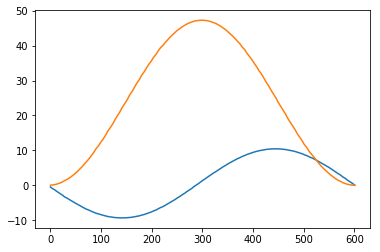

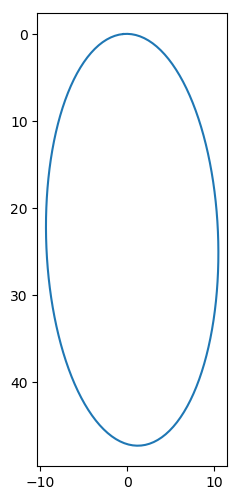

In [13]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[2:-1]=0+0j # 0,1 のみ　
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]])

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:849: MathTextWarning: Font 'default' does not have a glyph for '\u301c' [U+301c]
  MathTextWarning)
/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/mathtext.py:850: MathTextWarning: Substituting with a dummy symbol.
  warn("Substituting with a dummy symbol.", MathTextWarning)


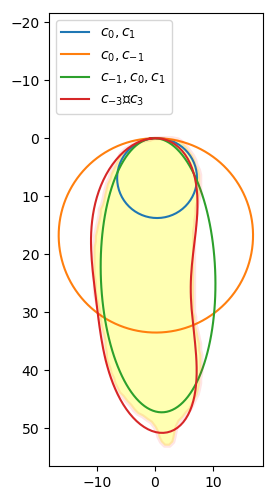

In [14]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.rcParams['font.family'] = '07YasashisaGothic' #全体のフォントを設定
W_cut = W.copy()
W_cut[2:]=0
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 
# 復元
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format("$c_0,c_1$"))

W_cut = W.copy()
W_cut[1:-1]=0
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 
# 復元
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format("$c_0,c_{-1}$"))


W_cut = W.copy()
W_cut[2:-1]=0 
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 
# 復元
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format("$c_{-1},c_0,c_1$"))

W_cut = W.copy()
W_cut[4:-3]=0 
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 
# 復元
plt.rcParams['font.family'] = '07YasashisaGothic' #全体のフォントを設定
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}〜{}".format("$c_{-3}$","$c_3$"))


# 完全逆変換
w_ifft = np.fft.ifft(W)
w_ifft = np.r_[w_ifft,[w_ifft[0]]]
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between( z.real,z.imag, facecolor='yellow', alpha=0.3 )
plt.plot(0,-18)
plt.legend(loc="upper left") # 凡例を表示

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


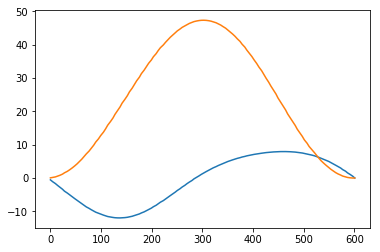

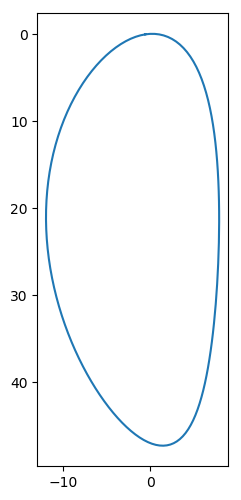

In [15]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[3:-2]=0+0j # 0,1,2のみ　
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]])

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


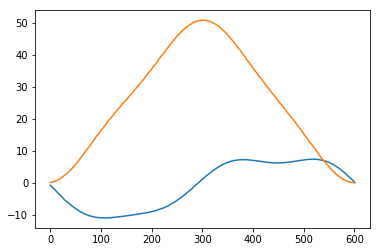

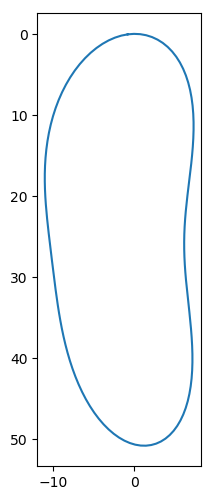

In [16]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[ 4:-3]=0+0j # 0,1 ,2、３ 　
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]])

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


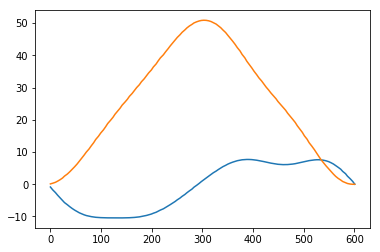

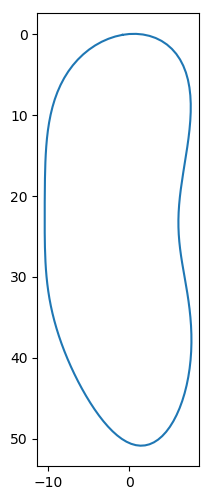

In [17]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[5:-4]=0+0j # 0,1 ,2,3 ,4
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]])

/Users/dan/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['07YasashisaGothic'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


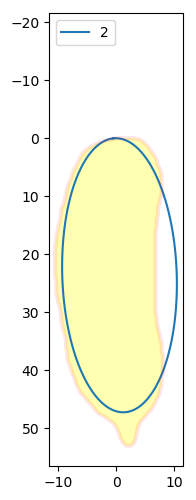

In [21]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(2,3):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format(cutn))
    
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]], facecolor='yellow', alpha=0.3 )
plt.plot(0,-18)
plt.legend(loc="upper left") # 凡例を表示

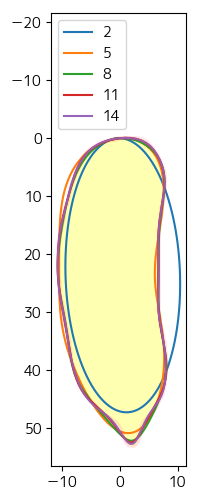

In [25]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(2,15,3):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format(cutn))
    
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]], facecolor='yellow', alpha=0.3 )
plt.plot(0,-18)
plt.legend(loc="upper left") # 凡例を表示

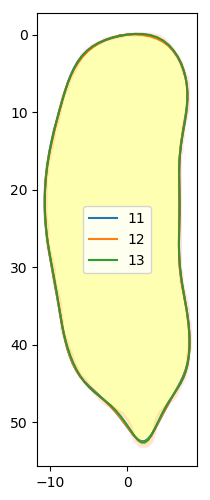

In [17]:
# 11-14項 近似
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(11,14):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format(cutn))
    
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]], facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

# 開曲線のフーリエ変換

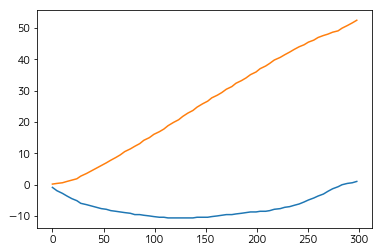

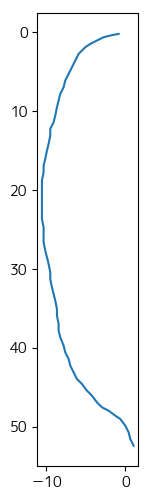

In [78]:
HSPANS=64
# 複素表現
# (x,y)と 複素数 x+ jy を同一視する。
z = [x + y*1j  for [x,y] in samples]
# 偏角の複素表現
w = [(z1 - z0)/allLength*SPANS for (z1,z0) in zip(z[1:],z[:-1])]
w.append((z[0] - z[-1])/allLength*SPANS)
w = np.array(w)
# フーリエ変換
W= np.fft.fft(w[:HSPANS]) #  半分だけ使って変換
# フーリエ逆変換
w_ifft= np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
plt.plot([lengs[i] for i in s_indexies[:HSPANS]],z.real)
plt.plot([lengs[i] for i in s_indexies[:HSPANS]],z.imag)
# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(z.real,z.imag)

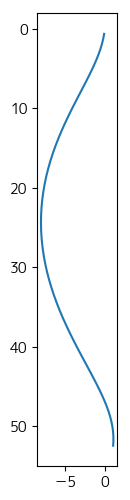

In [82]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[2:-1]=0+0j # 0,1 のみ　
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) 

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(z.real,z.imag)

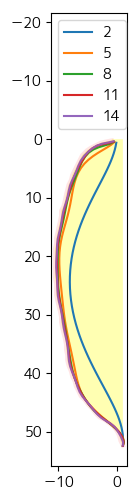

In [80]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(2,15,3):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(z.real,z.imag,label="{}".format(cutn))
    
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(z.real,z.imag,lw=3,alpha=0.1,color='red')
plt.fill_between(z.real,z.imag, facecolor='yellow', alpha=0.3 )
plt.plot(0,-18)
plt.legend(loc="upper left") # 凡例を表示

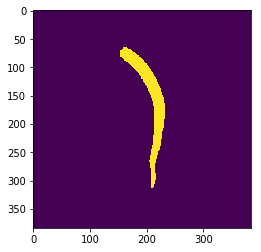

In [18]:
img = aomidaimg
plt.imshow(img)

(205.0, 162.0, (153, 66, 79, 249, 4474))

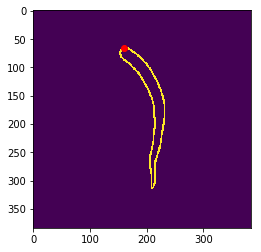

In [19]:
# 輪郭情報
c_x,c_y,(x0,y0,w0,h0,areas) = getCoG(img) # 重心とバウンディングボックスと面積
_image, contours, _hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) # 輪郭線追跡
cnt00 = contours[np.argmax([len(c) for c in contours])] # 最も長い輪郭
cnt00 = shaver(cnt00)
canvas = np.zeros_like(img)
canvas = cv2.drawContours(canvas,[cnt00],-1,255,2)
plt.scatter([cnt00[0][0][0]],[cnt00[0][0][1]],color="red")
plt.imshow(canvas)
c_x,c_y,(x0,y0,w0,h0,areas)

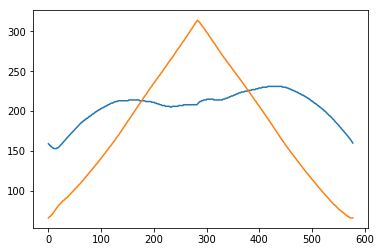

In [20]:
# 輪郭に沿った長さの列 
lengs = [cv2.arcLength(cnt00[:i+1],False)  for i in range(len(cnt00))]
plt.plot(lengs,[x for [[x,y]] in cnt00 ])
plt.plot(lengs,[y for [[x,y]] in cnt00 ])

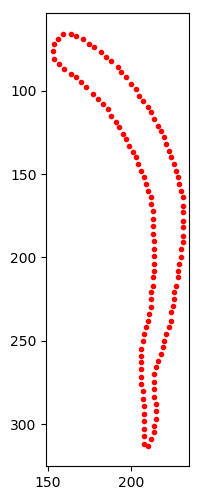

In [21]:
# 輪郭点を 128 分割したい
SPANS = 128
allLength = cv2.arcLength(cnt00,True) # 輪郭の長さ
needLengs = np.linspace(0,allLength,SPANS+1)
s_indexies = []
index = 0
for i in range(SPANS):
    nl = needLengs[i]
    for j in range(index,len(cnt00)):
        l0,l1 = lengs[j],lengs[j+1]
        if l0 <= nl and nl <= l1:
            if np.sqrt((l0-nl)**2) < np.sqrt((l1-nl)**2):
                s_indexies.append(j)
                index = j+1
            else:
                s_indexies.append(j+1)
                index = j+2
            break
samples =  np.array([[cnt00[i][0][0],cnt00[i][0][1]]  for i  in s_indexies])
# 表示して確認
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.scatter(samples[:,0],samples[:,1] ,marker='.',color="red")

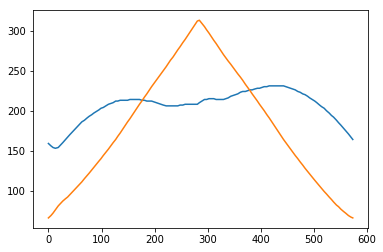

In [22]:
# 128点でX,Yを横軸を経路長としてプロット
plt.plot([lengs[i] for i in s_indexies],samples[:,0])
plt.plot([lengs[i] for i in s_indexies],samples[:,1])

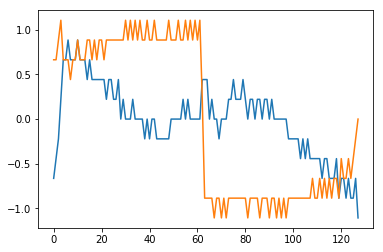

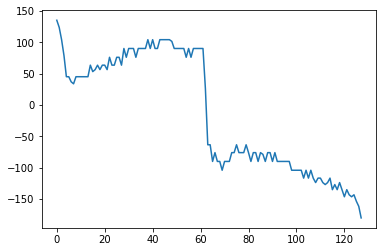

In [23]:
# 複素表現
# (x,y)と 複素数 x+ jy を同一視する。
z = [x + y*1j  for [x,y] in samples]
# 偏角の複素表現
w = [(z1 - z0)/allLength*SPANS for (z1,z0) in zip(z[1:],z[:-1])]
w.append((z[0] - z[-1])/allLength*SPANS)
w = np.array(w)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.real)
plt.plot(np.linspace(0,SPANS-1,SPANS),w.imag)
plt.show()
# 偏角(degree)のプロット
import cmath
ph = [180*cmath.phase(w[0])/np.pi]
for c in w[1:]:
    ph.append((180*cmath.phase(c)/np.pi) if abs(180*cmath.phase(c)/np.pi - ph[-1]) < 180  else (180*cmath.phase(c)/np.pi -360))
plt.plot(np.linspace(0,SPANS-1,SPANS),ph)

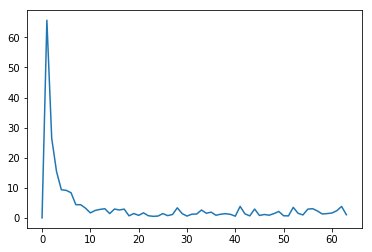

In [24]:
# フーリエ変換
W= np.fft.fft(w)

# スペクトラム表示
W_abs = np.abs(W)
W_abs_amp = W_abs / SPANS *2 # 交流成分はデータ数で割って2倍
W_abs_amp[0] = W_abs_amp[0] / 2 # 直流成分（今回は扱わないけど）は2倍不要

fq = np.linspace(0,  int(SPANS/2)-1,  int(SPANS/2))
plt.plot(fq, W_abs[: int(SPANS/2)])

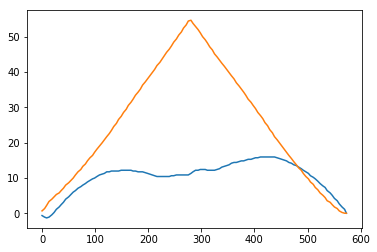

In [25]:
# フーリエ逆変換
w_ifft= np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
len(z) ,z.real,z.imag
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

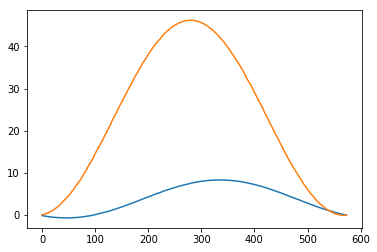

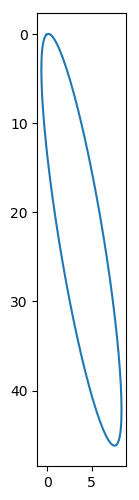

In [26]:
#  ローパスパスフィルタを通してフーリエ逆変換
W_cut = W.copy()
W_cut[2:-1]=0+0j # 0,1 のみ　
w_ifft = np.fft.ifft(W_cut)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
    s = z[-1]+ w_ifft[i]
    z.append(s)
z = np.array(z) #*10+100j+100
plt.plot([lengs[i] for i in s_indexies],z.real)
plt.plot([lengs[i] for i in s_indexies],z.imag)

# 復元
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]])

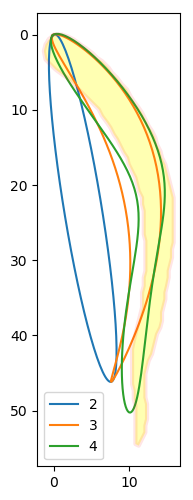

In [27]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(2,5):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format(cutn))
    
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]], facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

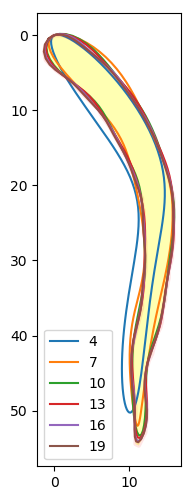

In [28]:
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(4,20,3):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format(cutn)) 
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]], facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

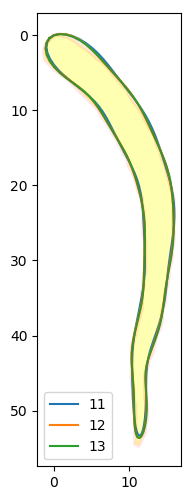

In [29]:
# 11-14項 近似
#  ローパスフィルタを通してフーリエ逆変換
plt.figure(figsize=(6,6),dpi=100)
plt.gca().set_aspect('equal', adjustable='box')
plt.gca().invert_yaxis() 

for  cutn  in range(11,14):
    W_cut = W.copy()
    W_cut[cutn:1-cutn]=0 
    w_ifft = np.fft.ifft(W_cut)
    z =[w_ifft[0]]
    for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
    z = np.array(z)
    plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],label="{}".format(cutn))
    
# 完全逆変換
w_ifft = np.fft.ifft(W)
z =[w_ifft[0]]
for i in range(1,len(w_ifft)):
        s = z[-1]+ w_ifft[i]
        z.append(s)
z = np.array(z)
plt.plot(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]],lw=3,alpha=0.1,color='red')
plt.fill_between(np.r_[z.real,z.real[0]],np.r_[z.imag,z.imag[0]], facecolor='yellow', alpha=0.3 )
plt.legend() # 凡例を表示

参考

http://www.design.kyushu-u.ac.jp/lib/doctor/1999/k032/k032-03.pdf

http://lbm.ab.a.u-tokyo.ac.jp/~iwata/software/shape_r/shape_r_ppt.pdf

http://www.ic.is.tohoku.ac.jp/~swk/lecture/yaruodsp/dft.html#SECTION00850000000000000000